In [3]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL, time, random, os, zipfile
from sklearn.model_selection import train_test_split

from IPython import display

from gan_network import *
from dataset_utils import *

In [7]:
# Enviroment parameters 
USE_GPU = True
INFO_BATCH = 50

# Network parameters
CHECKPOINT_PATH = './checkpoint/portrait_model.pt'
ENC_PRETRAINED = True
LOAD_MODEL = True
MASK_ACT = 'tanh'
DEC_ACT = 'tanh'
UNITS = 64
LR = 2e-4
W_GRAM = 200
EPOCHS = 10

# Dataset parameters
WIKI_PATH = "./data/portrait_dataset.npz"
CELEB_TRAIN_SIZE = 4940
CELEB_TEST_SIZE = 1236
NUM_STYLE = 5
NUM_CONTENT = 1
BATCH_SIZE = 64


# Dataset Load

In [9]:
# Reading CelebaDataset (content dataset)

!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
    zip_ref.extractall("data_faces/")

--2020-12-23 15:16:24--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.41
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  94.1MB/s    in 14s     

2020-12-23 15:16:39 (94.9 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [8]:
# Preparing CelebaDataset (content dataset)

CELEB_ROOT = './data_faces/img_align_celeba'
file_list = os.listdir(CELEB_ROOT)
random.shuffle(file_list)

train_file_list = file_list[:CELEB_TRAIN_SIZE]
valid_file_list = file_list[CELEB_TRAIN_SIZE: CELEB_TRAIN_SIZE+CELEB_TEST_SIZE]

celeb_train_dataset = torch.utils.data.DataLoader(
    CelebaDataset(train_file_list, CELEB_ROOT), 
    shuffle=False, batch_size=BATCH_SIZE
    )

celeb_valid_dataset = torch.utils.data.DataLoader(
    CelebaDataset(valid_file_list, CELEB_ROOT), 
    shuffle=False, batch_size=BATCH_SIZE
    )

In [9]:
# Reading WikiArtDataset (style dataset)

wiki_dataset = np.load(WIKI_PATH, allow_pickle=True)
wiki_dataset_images = wiki_dataset['imgs']
wiki_dataset_labels = wiki_dataset['labels']
wiki_label_encoder = wiki_dataset['label_encoder'][0]

In [10]:
# Preparing WikiArtDataset (style dataset)

x_train, x_valid, y_train, y_valid = train_test_split(wiki_dataset_images, wiki_dataset_labels, test_size=0.2, 
                                                      shuffle=True,
                                                      random_state=42)

wiki_train_dataset = WikiartDataset(x_train, y_train)
wiki_train_dataset = torch.utils.data.DataLoader(wiki_train_dataset, shuffle=False, batch_size=BATCH_SIZE)

wiki_valid_dataset = WikiartDataset(x_valid, y_valid)
wiki_valid_dataset = torch.utils.data.DataLoader(wiki_valid_dataset, shuffle=False, batch_size=BATCH_SIZE)

# Network training

In [11]:
def plot_samples(model, content_ds, style_ds, use_gpu=USE_GPU):
    model.eval()
    with torch.no_grad():
        vx, vy = iter(content_ds).next()
        vsx, vsy = iter(style_ds).next()

        if use_gpu:
          _, mix_img = model(vx.cuda(), vy.cuda(), vsx.cuda(), vy.cuda())
          mix_img = mix_img.cpu()
        else:
          _, mix_img = model(vx, vy, vsx, vy)

    plt.figure(figsize=(10, 8))
    for i in range(3):
        plt.subplot(330 + i*3 + 1)
        plt.imshow(np.transpose(vx.numpy()[i], (1, 2, 0)))
        plt.axis('off')

        plt.subplot(330 + i*3 + 2)
        plt.imshow(np.transpose(vsx.numpy()[i], (1, 2, 0)))
        plt.axis('off')

        plt.subplot(330 + i*3 + 3)
        plt.imshow(np.transpose(mix_img.numpy()[i], (1, 2, 0)))
        plt.axis('off')

        plt.show()

In [12]:
# Initialize Model & Optimizers

model = GAN(num_style=NUM_STYLE, num_content=NUM_CONTENT,
            units=UNITS, gen_enc_pretrained=ENC_PRETRAINED,
            gen_mask_activation=MASK_ACT, gen_dec_activation=DEC_ACT,
            w_gram=W_GRAM, use_cuda=USE_GPU)

gen_optimizer = torch.optim.Adam([{'params':model.generator.mask.parameters(), 
                                   'params':model.generator.decoder.parameters()}], LR)

disc_optimizer = torch.optim.Adam(model.discriminator.parameters(), LR)

In [13]:
# Load the model

if LOAD_MODEL:
    gen_optimizer, disc_optimizer, TRAINED_EPOCH, TRAINED_LOSS  = model.load_model(gen_optimizer,
                                                                                   disc_optimizer,
                                                                                   CHECKPOINT_PATH)
    print(f":: Loaded epoch {TRAINED_EPOCH}, loss {TRAINED_LOSS}")
else:
    TRAINED_LOSS = 100000
    TRAINED_EPOCH = 0

if USE_GPU:
    model = model.cuda()
    gen_optimizer = torch.optim.Adam([{'params':model.generator.mask.parameters(), 
                                       'params':model.generator.decoder.parameters()}], LR)
    disc_optimizer = torch.optim.Adam(model.discriminator.parameters(), LR)

:: Loaded epoch 744, loss 2.192641019821167


In [14]:
def train(epochs, model, content_ds, style_ds, gen_opt, disc_opt,
          content_ds_valid, style_ds_valid, 
          save, trained_loss, trained_epoch,
          disc_ratio=0.3, use_gpu=False, info_batch=200):
  
    style_iter = iter(style_ds)
    gen_loss = 0; style_loss = 0; binary_loss = 0;
    total_time = 0; time_spent = 0;

    # Epochs start
    for epoch in range(epochs):

        # Plotting results and last epoch info
        display.clear_output(wait=True)
        plot_samples(model, content_ds_valid, style_ds_valid, use_gpu=USE_GPU)
        print(f">> Epoch {epoch+1} started...\t Last time iter {time_spent:.2f} sec, " + 
              f"Total time spent {total_time:.2f} sec - " + 
              f"Last \033[92mGen Loss {gen_loss/len(style_ds):.4f}\033[0m, " +
              f"\033[91mDisc Loss {(style_loss+binary_loss)/len(content_ds):.4f}\033[0m")
    
        start_time = time.time()
        gen_loss = 0; style_loss = 0; binary_loss = 0;

        # fool the discriminator  
        fool_ratio = disc_ratio / max(trained_epoch, 1.0)
        print(f":: Ratio of fooling (disc) for GAN training {fool_ratio}")

        # Training
        model.train()

        # Content images
        for i, (c_input, c_target) in enumerate(content_ds):

            # Style images
            try:
                s_input, s_target = style_iter.next()
            except StopIteration:
                style_iter = iter(style_ds)
                s_input, s_target = style_iter.next()

            if use_gpu:
                c_input, c_target = c_input.cuda(), c_target.cuda()
                s_input, s_target = s_input.cuda(), s_target.cuda()

            #use reconstruction instead of real image to make discriminator harder
            use_real = random.random() > fool_ratio  

            # Discriminator backprop
            disc_opt.zero_grad()
            dloss, style_loss, binary_loss = model.train_discriminator(c_input, c_target,
                                                                       s_input, s_target,
                                                                       style_loss, binary_loss,
                                                                       use_real=use_real)
            if dloss is not None:
                dloss.backward()
                disc_opt.step()

            # Generator backprop
            gen_opt.zero_grad()
            model.update_requires_grad(model.discriminator, update=False) # freeze discriminator
            model.update_requires_grad(model.generator.mask, update=True) # unfreeze generator
            model.update_requires_grad(model.generator.decoder, update=True) # unfreeze generator

            loss, mix_img = model(c_input, c_target, s_input, s_target)
            if loss is not None and len(loss) > 0:
                sumloss = sum(loss)
                sumloss.backward()
                gen_loss += sumloss
                gen_opt.step()

            # Print loss info for batch
            if i % info_batch == 0:
            print("\t" + "-"*50)
            print(f"\t:: Batch {i} -> Disc Loss {dloss/(i+1):.4f}, Style Loss {style_loss/(i+1):.4f}," +
                  f" Binary Loss {binary_loss/(i+1):.4f}")
            print(f"\t:: Batch {i} -> Generator Loss {gen_loss/(i+1):.4f}")
            print(f"\t:: Time taken {time.time()-start_time} sec...")

        # Print end of epoch info
        time_spent = time.time()-start_time
        total_time += time_spent
        print(f":: Epoch {epoch+1} -> \033[92mGen Loss {gen_loss/len(content_ds):.4f}\033[0m," + 
              f" \033[91mDisc Loss {(style_loss+binary_loss)/len(content_ds):.4f}\033[0m")
        print(f":: Time taken {time_spent} sec...\n") 

        # Save model
        if save and gen_loss/len(content_ds) < trained_loss:
            trained_loss = gen_loss/len(content_ds)
            trained_epoch += 1
            model.save(gen_opt, disc_opt, trained_epoch, trained_loss, CHECKPOINT_PATH)
        else:
            trained_epoch += 1

    return model, trained_loss, trained_epoch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


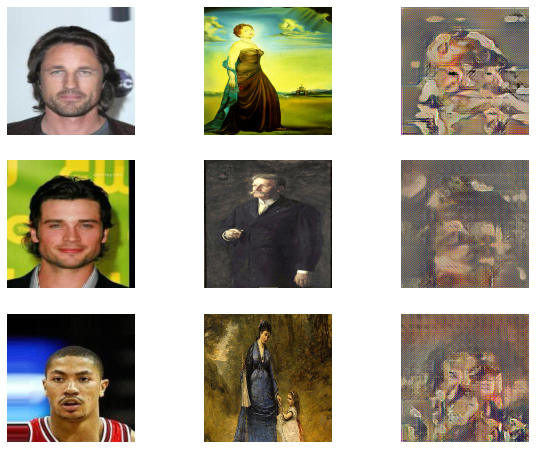

>> Epoch 10 started...	 Last time iter 121.41 sec, Total time spent 1084.78 sec - Last Gen Loss 3.3756, Disc Loss 0.9323
:: Ratio of fooling (disc) for GAN training 0.000398406374501992
	--------------------------------------------------
	:: Batch 0 -> Disc Loss 0.8140, Style Loss 0.0001, Binary Loss 0.8140
	:: Batch 0 -> Generator Loss 3.4225
	:: Time taken 1.7298212051391602 sec...
	--------------------------------------------------
	:: Batch 50 -> Disc Loss 0.0156, Style Loss 0.4285, Binary Loss 0.4264
	:: Batch 50 -> Generator Loss 3.3122
	:: Time taken 80.34172511100769 sec...
:: Epoch 10 -> Gen Loss 3.2821, Disc Loss 0.8430
:: Time taken 121.4074432849884 sec...



In [15]:
trained_model, trained_loss, trained_epoch = train(EPOCHS, model, celeb_train_dataset, wiki_train_dataset, 
                                                   gen_optimizer, disc_optimizer, 
                                                   celeb_valid_dataset, wiki_valid_dataset, 
                                                   save=True, 
                                                   trained_loss=TRAINED_LOSS, trained_epoch=TRAINED_EPOCH,
                                                   use_gpu=USE_GPU, info_batch=INFO_BATCH)